In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import pysam
import os

def Find_patient_information(patient_ID):
    patient_information = ["patient_ID","patient_type","IBD","day","month","year","seqID_virome"] 
    data_frame = pd.read_csv("PHAGE_BUBBLE/Freeze3_metadata.csv", header=0,
                             dtype=str, na_values=['NA'],
                             skip_blank_lines=True,
                             true_values=['true'], false_values=['false'],
                             nrows=None)

    
    patient_ID_whole_metadata = data_frame[data_frame["patient_ID"] == patient_ID] # Select all the row with the patient_ID
    selected_data = patient_ID_whole_metadata[patient_information] # select all the column within this list
    selected_data = selected_data.dropna(subset=["seqID_virome"]) # Remove all rows with 'NaN' in the SeqID column 
    return selected_data

def condense_data_file_and_time(data):
    Time_dict = {'Time': [f"{day}-{month}-{year}" for day, month, year in zip(data['day'], data['month'], data['year'])]}
    File_name_dict = {'File_name': [f"{seqID_virome}" for seqID_virome in data['seqID_virome']]}
    Time_dict.update(File_name_dict)
    return Time_dict
    
def write_output_for_Bash_command(data, patient_ID): # take data from the condense_data_file_and_time Function
    output_file_path = f'Time_series/Sample_output/{patient_ID}_sample_output.txt'
    with open(output_file_path, 'w') as file:
        for item in data["seqID_virome"]:
            if not pd.isna(item):
                file.write("%s\n" % item)
    
def Find_bamfiles(folder_path, FILE_ID):       
    file_list = [
        os.path.join(folder_path, filename)
        for filename in os.listdir(folder_path)
        if filename.startswith(tuple(FILE_ID)) and filename.endswith(".bam")
    ]
    return file_list

def Find_Library_Size(Library_size_matrix):
    data_frame = pd.read_csv(Library_size_matrix, sep='\t')
    Identification = data_frame.iloc[:,0]
                
    size_dict = {}
    for id_value in Identification:
        try:
            Library_Size = data_frame.loc[data_frame['Sample_name'] == id_value, 'Libary_Size'].values[0]
            size_dict[id_value] = Library_Size
        except IndexError:
            print(f"ID '{id_value}' not found in the table.")
            return None
    return size_dict

def Find_contigs(filepaths):
    contigs = []
    for record in SeqIO.parse(filepaths, "fasta"):
        contigs.append(record.id) 
    return contigs

In [332]:
def Find_relative_abundance(component, Patient_ID, File_Time_dict):   
    File_name = File_Time_dict["File_name"]
    Dict_Sample_ID = Find_Library_Size("PHAGE_BUBBLE/sampleSeqCounts.tsv") # METAdata file, cannot change
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta") # Component file location, fixed.
    File_name_lists = Find_bamfiles(f"Time_series/Patient_sample/{Patient_ID}/{component}", File_name) # location of bamfiles sorted, fixed.
    
    dict_data = {}
    for ID in File_name:
        bam_files = [file_path for file_path in File_name_lists if file_path.startswith(f"Time_series/Patient_sample/{Patient_ID}")]
        if ID not in dict_data:
            dict_data[ID] = {}
        for bam_file in bam_files:
            if ID in bam_file:
                # print(bam_file)
                with pysam.AlignmentFile(bam_file, 'rb') as bamfile:               
                    for references in bamfile.references:
                        mapped_reads = bamfile.count(reference=references,
                                                     read_callback=lambda read: not read.is_unmapped) 
                        genome_length = bamfile.get_reference_length(references)
                        for id_value, library_size in Dict_Sample_ID.items():
                            if id_value in bam_file:
                                Library_Size = library_size  
                            # print(f"{references}: mapped read = {mapped_reads}")
                            # print(f"Genome length = {genome_length}")
                        Rel_Ab = (mapped_reads * (1000000))/(Library_Size * genome_length)
                        if Rel_Ab < 0.001:
                            Rel_Ab = 0
                        else: 
                            Rel_Ab = Rel_Ab
                        # print(f"{ID}:{references}: Library_size = {Library_Size}: mapped read = {mapped_reads}: Rel_Ab = {Rel_Ab}")     
                        dict_data[ID][references] = Rel_Ab # Append the Relative abundance into the correct ID dictiondary in a list.
    return dict_data

def Find_relative_abundance_scratch(component, Patient_ID, File_Time_dict):   
    File_name = File_Time_dict["File_name"]
    Dict_Sample_ID = Find_Library_Size("PHAGE_BUBBLE/sampleSeqCounts.tsv") # METAdata file, cannot change
    contigs = Find_contigs(f"PHAGE_BUBBLE/Paths/{component}_file/{component}_combined_file.fasta") # Component file location, fixed.
    File_name_lists = Find_bamfiles(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}/{component}", File_name) # location of bamfiles sorted, fixed.
    
    dict_data = {}
    for ID in File_name:
        bam_files = [file_path for file_path in File_name_lists if file_path.startswith(f"/scratch/user/pham0323/Time_series/Patient_sample/{Patient_ID}")]
        if ID not in dict_data:
            dict_data[ID] = {}
        for bam_file in bam_files:
            if ID in bam_file:
                # print(bam_file)
                with pysam.AlignmentFile(bam_file, 'rb') as bamfile:               
                    for references in bamfile.references:
                        mapped_reads = bamfile.count(reference=references,
                                                     read_callback=lambda read: not read.is_unmapped) 
                        genome_length = bamfile.get_reference_length(references)
                        for id_value, library_size in Dict_Sample_ID.items():
                            if id_value in bam_file:
                                Library_Size = library_size  
                            # print(f"{references}: mapped read = {mapped_reads}")
                            # print(f"Genome length = {genome_length}")
                        Rel_Ab = (mapped_reads * (1000000))/(Library_Size * genome_length)
                        if Rel_Ab < 0.001:
                            Rel_Ab = 0
                        else: 
                            Rel_Ab = Rel_Ab
                        # print(f"{ID}:{references}: Library_size = {Library_Size}: mapped read = {mapped_reads}: Rel_Ab = {Rel_Ab}")     
                        dict_data[ID][references] = Rel_Ab # Append the Relative abundance into the correct ID dictiondary in a list.
    return dict_data

In [358]:
# Making a new Table for Data Analysis:
# Relative Abundance base prediction:
import pandas as pd
patient_ID_list =['230_4','282','1012A','2093A','2028A','2037A']
patient_ID_list_scratch =['2064A','2065A','228','203','2036A','2032A','2056A','2057A','2066A','234','268']
patient_information = ["patient_ID","seqID_virome", "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare"]
                       # "FC_categories", "FC_categories_4", "inflammation", "flare",
                       # "type_flare", "disease_status", "current_medications"] 
Component = ['phage_comp_5', 'phage_comp_10', 'phage_comp_21', 'phage_comp_24', 'phage_comp_26', 'phage_comp_27', 'phage_comp_28',
 'phage_comp_31', 'phage_comp_45', 'phage_comp_46', 'phage_comp_65', 'phage_comp_73', 'phage_comp_76', 'phage_comp_86',
 'phage_comp_87', 'phage_comp_93', 'phage_comp_105', 'phage_comp_122', 'phage_comp_142']

def Find_Patient_Information(List):
    data_frame = pd.read_csv("PHAGE_BUBBLE/Freeze3_metadata.csv", header=0,
                             dtype=str, na_values=['NA'],
                             skip_blank_lines=True,
                             true_values=['true'], false_values=['false'],
                             nrows=None)
    data_frame['sample_date_converted_eu'] = pd.to_datetime(data_frame['sample_date_converted_eu'], format = '%d_%m_%Y')
    data_frame = data_frame.sort_values(by='sample_date_converted_eu')
    patient_ID_whole_metadata = data_frame[data_frame["patient_ID"].isin(List)]

    selected_data = patient_ID_whole_metadata[patient_information]
    selected_data = selected_data.dropna(subset=["seqID_virome"])
    selected_data.to_csv('selected_data.tsv', sep='\t', index=False)
    return selected_data



def Combine_Metadata_ID_and_Relative_abundance(Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    # Dict_2 = Find_relative_abundance(component, Patient_ID, Dict_1)
    merge_dict = {}
    for component in Component:
        ReAb_dict = Find_relative_abundance(component, Patient_ID, Dict_1)
        if not merge_dict:
            merge_dict = ReAb_dict
        else: 
            for key, value in ReAb_dict.items():
                merge_dict[key] = {**merge_dict.get(key, {}), **value}
    return merge_dict

def Combine_Metadata_ID_and_Relative_abundance_scratch(Patient_ID):
    Dict_1 = condense_data_file_and_time(Find_patient_information(Patient_ID)) # Dict_1 has patient's info skimmed down, it has Filename and Time.
    # Dict_2 = Find_relative_abundance(component, Patient_ID, Dict_1)
    merge_dict = {}
    for component in Component:
        ReAb_dict = Find_relative_abundance_scratch(component, Patient_ID, Dict_1)
        if not merge_dict:
            merge_dict = ReAb_dict
        else: 
            for key, value in ReAb_dict.items():
                merge_dict[key] = {**merge_dict.get(key, {}), **value}
    return merge_dict
    
def Turn_to_TSV(data):
    data = pd.DataFrame(data)
    data = data.T
    # for key in Dict_2.keys():
    #     data['SeqID_virome'] = key
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'seqID_virome'}, inplace=True)
    data.to_csv('Data.tsv', sep='\t', index=False)
    return data
    

Combined_data = {}
for patient in patient_ID_list:
    data = Combine_Metadata_ID_and_Relative_abundance(patient)
    Combined_data.update(data)
for patient_2 in patient_ID_list_scratch:
    data_scratch = Combine_Metadata_ID_and_Relative_abundance_scratch(patient_2)
    Combined_data.update(data_scratch)
print(Combined_data)


Combined_data_new = Turn_to_TSV(Combined_data)
Big_Table = Find_Patient_Information(patient_ID_list_meta) 
Big_Table = pd.DataFrame(Big_Table)
# print(Big_Table)
Big_Table.to_csv('patient_data.tsv', sep='\t', index=False)
merged_table = pd.merge(Combined_data_new, Big_Table, on='seqID_virome', how='inner')  # Use 'outer' to keep all rows
merged_table.to_csv('Data_for_heat_map.tsv', sep='\t', index=False)
print(f"TSV MADE")
# patient_0 = '2032A'
# Patient_1012A = Find_Patient_Information([patient_0])
# smaller_table = pd.DataFrame(Patient_1012A)
# smaller_table.to_csv(f'{patient_0}_patient_data.tsv', sep='\t', index=False)

{'M595_I7613_7562_Parkes_IBD_039-1_NEBNextIndex33_CAGGCG_S8_L001': {'phage_comp_5_cycle_1': 0, 'phage_comp_5_cycle_2': 0, 'phage_comp_5_cycle_3': 0, 'phage_comp_10_cycle_1': 0, 'phage_comp_10_cycle_3': 0, 'phage_comp_10_cycle_6': 0, 'phage_comp_21_cycle_1': 0, 'phage_comp_21_cycle_4': 0, 'phage_comp_21_cycle_5': 0, 'phage_comp_24_cycle_1': 0, 'phage_comp_24_cycle_2': 0, 'phage_comp_24_cycle_3': 0, 'phage_comp_26_cycle_1': 0, 'phage_comp_26_cycle_2': 0, 'phage_comp_27_cycle_1': 0, 'phage_comp_27_cycle_2': 0, 'phage_comp_28_cycle_1': 0, 'phage_comp_28_cycle_2': 0, 'phage_comp_28_cycle_3': 0, 'phage_comp_31_cycle_1': 0, 'phage_comp_31_cycle_2': 0, 'phage_comp_31_cycle_3': 0, 'phage_comp_31_cycle_4': 0, 'phage_comp_45_cycle_1': 0.012335546640809839, 'phage_comp_45_cycle_2': 0.005557299775837978, 'phage_comp_46_cycle_1': 0, 'phage_comp_46_cycle_2': 0, 'phage_comp_46_cycle_3': 0, 'phage_comp_65_cycle_1': 0, 'phage_comp_65_cycle_2': 0, 'phage_comp_73_cycle_1': 0, 'phage_comp_73_cycle_4': 0, '

In [ ]:
# Step 1: Read the TSV file into memory
file_path = "Data3.tsv"  # Replace with the path to your TSV file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Step 2: Identify the row you want to remove (for example, by its index)
row_to_remove_index = 2  # Replace with the index of the row you want to remove

# Step 3: Create a new TSV file without the selected row
new_lines = [line for i, line in enumerate(lines) if i != row_to_remove_index]

# Step 4: Optionally, replace the original TSV file with the new one
new_file_path = "Data3_no_Campy.tsv"  # Replace with the desired new file path
with open(new_file_path, 'w') as new_file:
    new_file.writelines(new_lines)

# Optional: If you want to replace the original file, you can do this:
import os
os.remove(file_path)  # Remove the original file
os.rename(new_file_path, file_path)  # Rename the new file to the original file name


In [88]:
# load the packages
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# import shap
from matplotlib import pyplot as plt

data =pd.read_csv('new_data.tsv', delimiter='\t')

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model (e.g., calculate metrics like mean squared error, R-squared)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

ValueError: could not convert string to float: 'yes'

TypeError: only integer scalar arrays can be converted to a scalar index

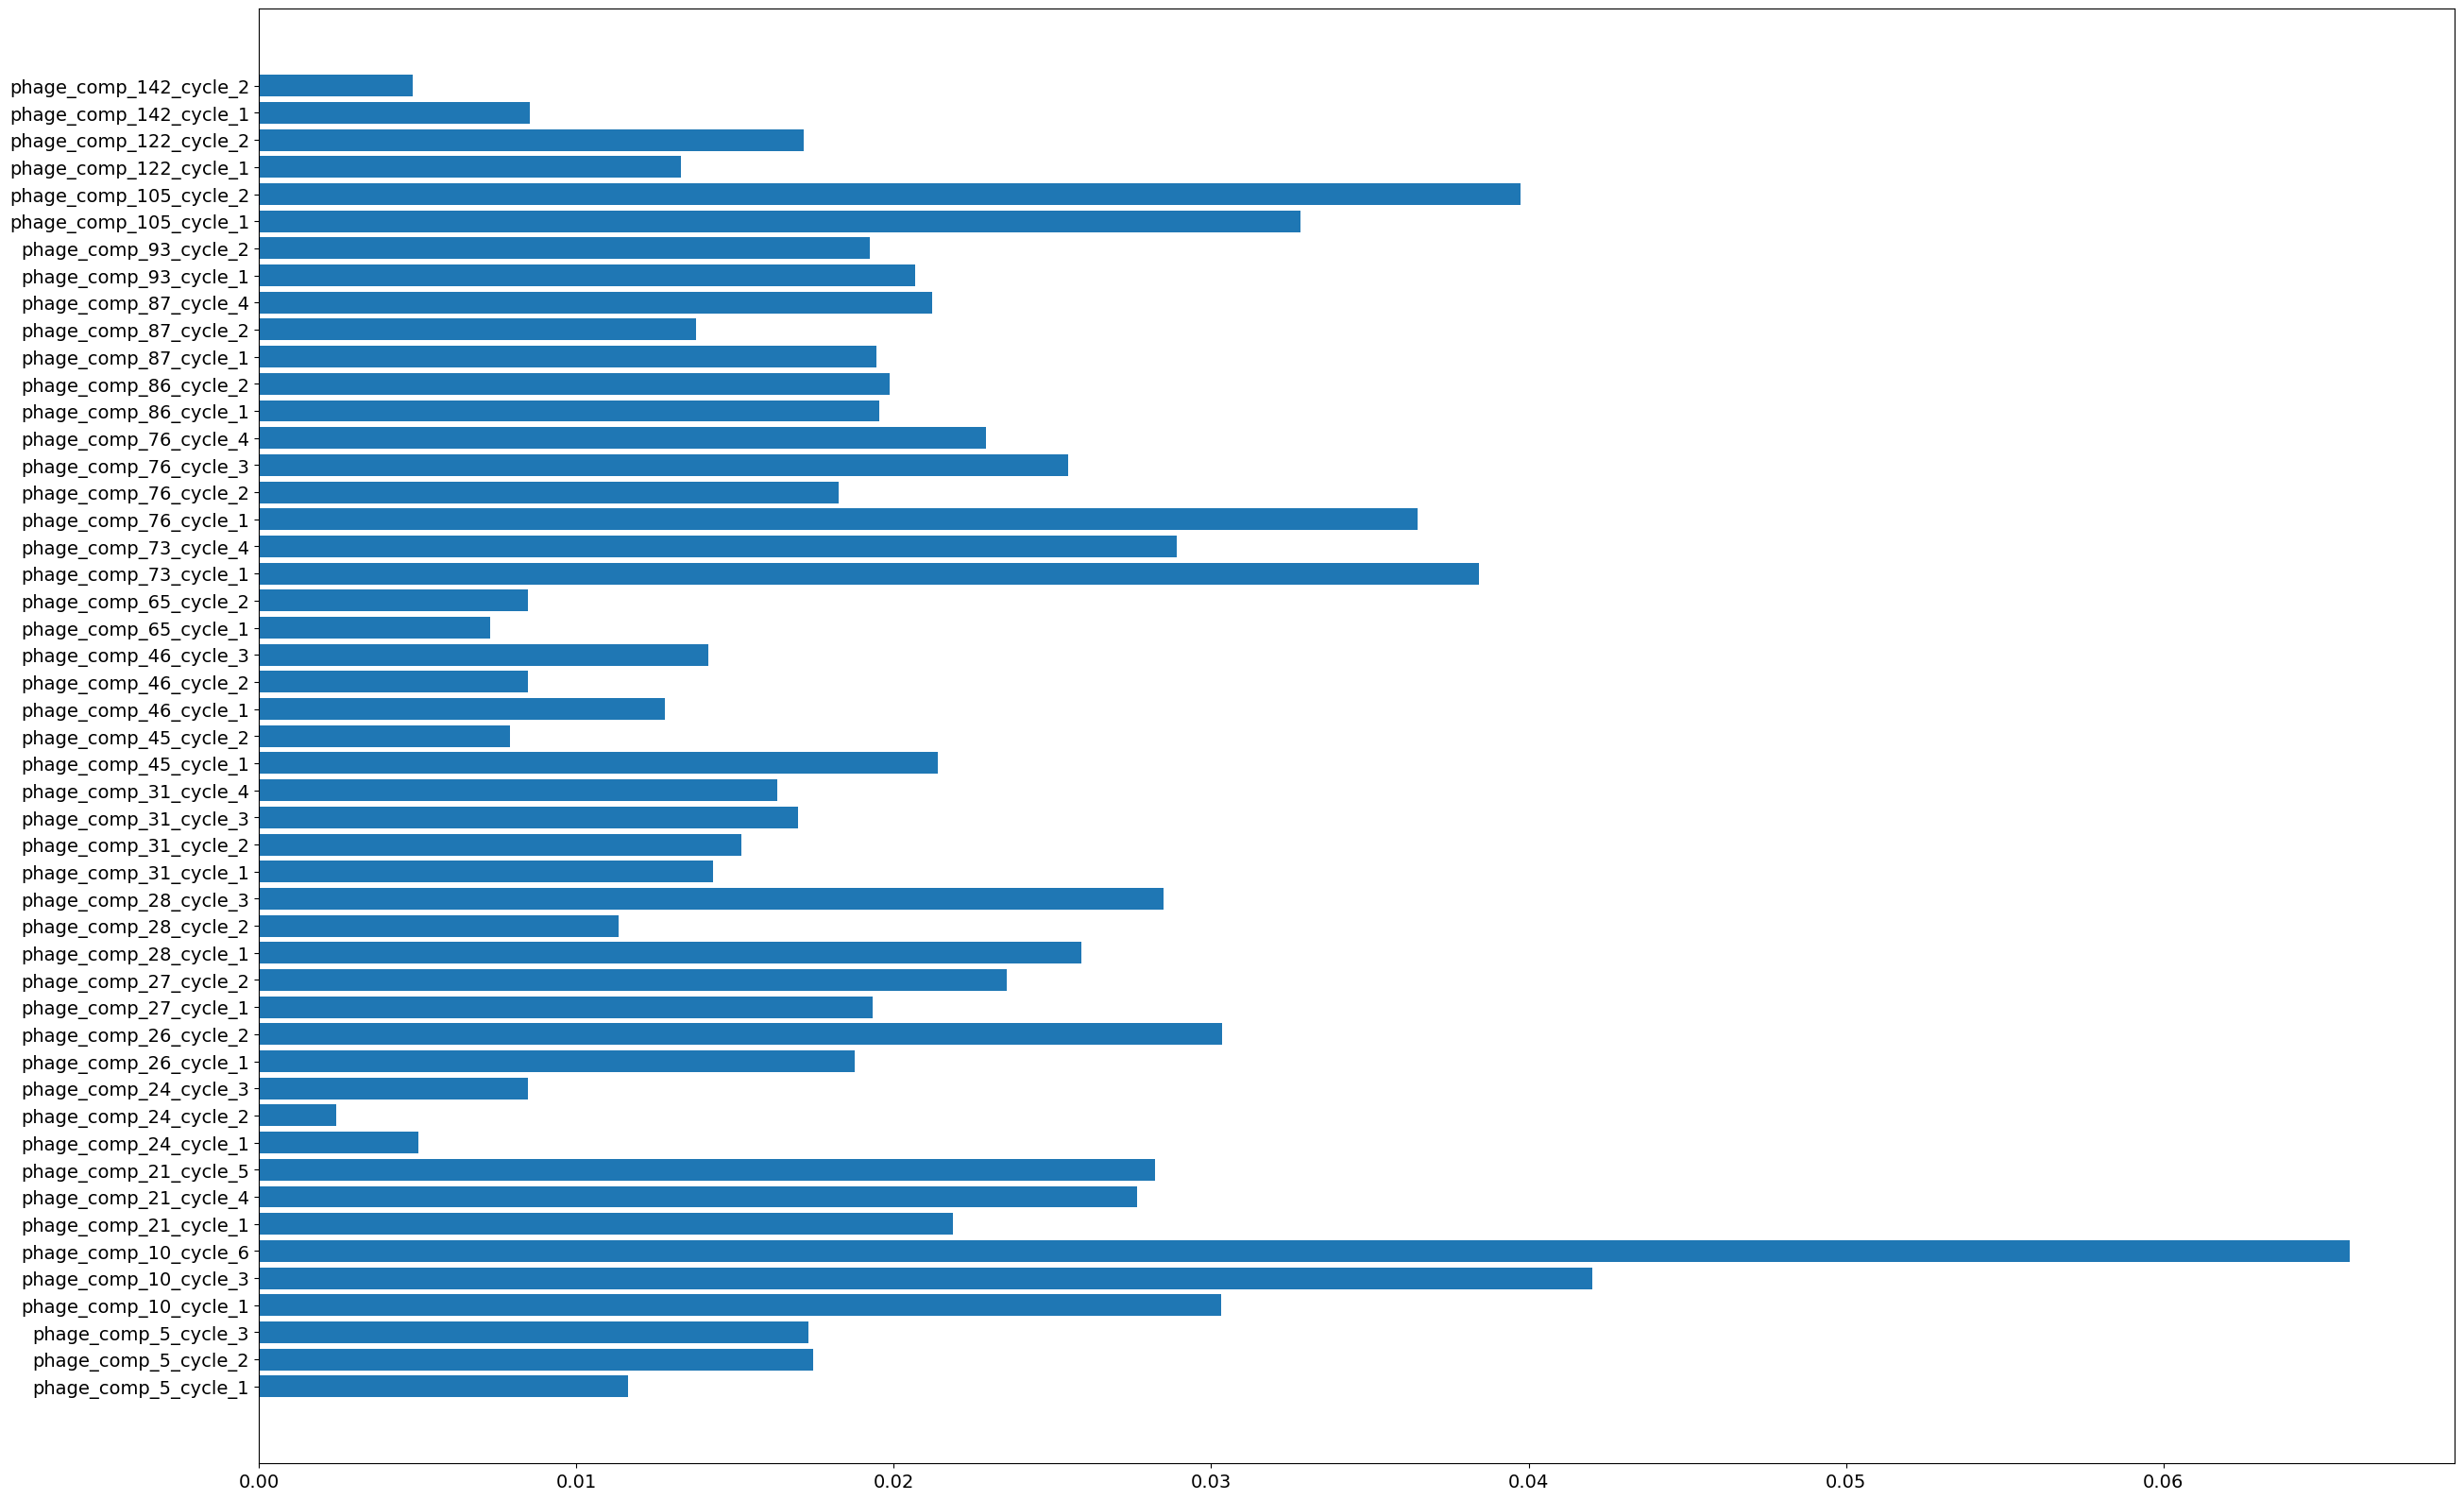

In [176]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
data =pd.read_csv('Data2.tsv', delimiter='\t')
patient_information = ["patient_ID","seqID_virome", "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare"]
data_for_x = data.drop(patient_information, axis=1)
feature_names =  data_for_x.columns.tolist()
# print(feature_names)

X = pd.DataFrame(data_for_x, columns=feature_names)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# define the model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
plt.figure(figsize=(30,20))
plt.barh(feature_names, rf.feature_importances_)
plt.savefig('Feature_importance_ALL_COMPONENTS.png', dpi=300, bbox_inches='tight', format="png")
# plot feature importance
sorted_idx = rf.feature_importances_.argsort()
plt.barh(feature_names[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

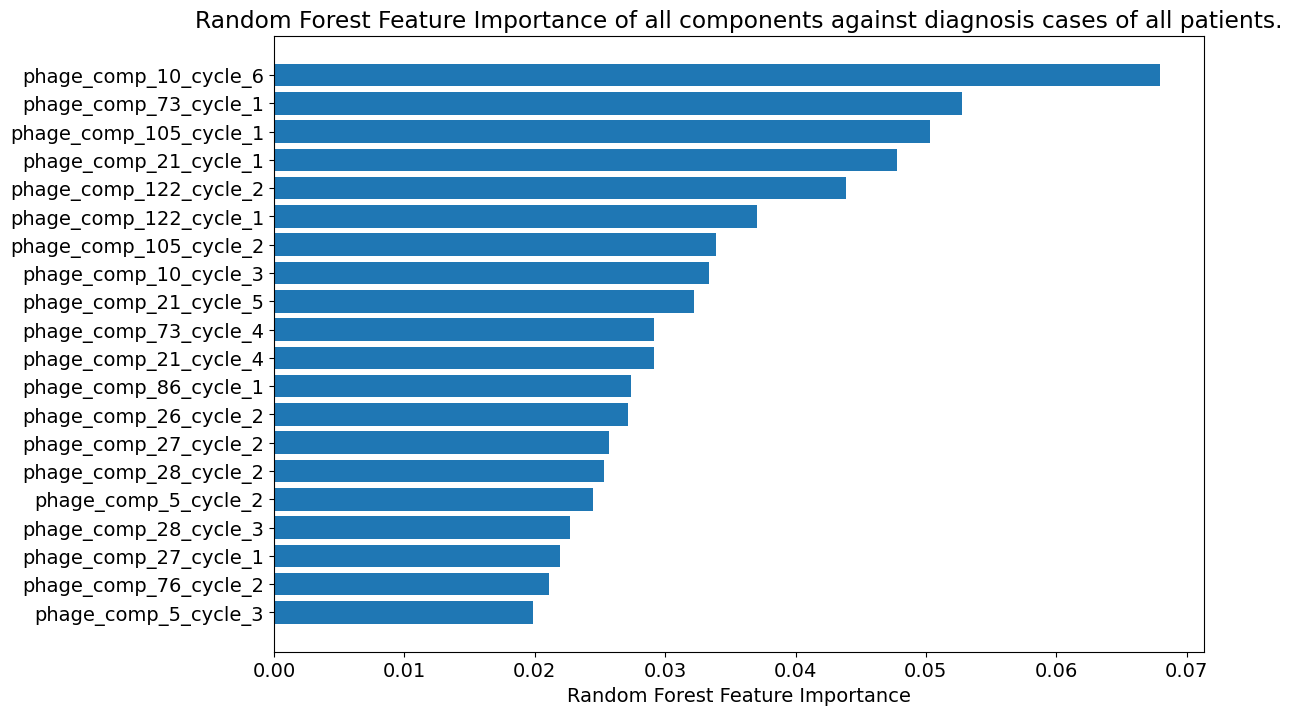

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('Data2.tsv', delimiter='\t')
# Define columns to exclude from features
patient_information = ["patient_ID","seqID_virome", "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare",
                       "type_flare", "disease_status", "current_medications"]

# Create your feature matrix (X) and target vector (y)
data_for_x = data.drop(patient_information, axis=1)
feature_names = data_for_x.columns.tolist()

X = pd.DataFrame(data_for_x, columns=feature_names)
y = data['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

# Define the model and fit it
rf = RandomForestClassifier(n_estimators=100, random_state=12)
rf.fit(X_train, y_train)

# Create a horizontal bar chart for feature importances
plt.figure(figsize=(12, 8))  # Adjust the figure size
n_features_to_display = 20  # Limit the number of displayed features

# Sort the features by importance
sorted_idx = rf.feature_importances_.argsort()[-n_features_to_display:]
plt.barh(range(n_features_to_display), rf.feature_importances_[sorted_idx])
plt.yticks(range(n_features_to_display), [feature_names[i] for i in sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title('Random Forest Feature Importance of all components against diagnosis cases of all patients.')
# Save the figure
plt.savefig('Feature_importance_ALL_COMPONENTS.png', dpi=300, bbox_inches='tight', format="png")

# Show the plot
plt.show()


phage_comp_76_cycle_2
phage_comp_27_cycle_1
phage_comp_28_cycle_3
phage_comp_5_cycle_2
phage_comp_28_cycle_2
phage_comp_27_cycle_2
phage_comp_26_cycle_2
phage_comp_86_cycle_1
phage_comp_21_cycle_4
phage_comp_73_cycle_4
phage_comp_21_cycle_5
phage_comp_10_cycle_3
phage_comp_105_cycle_2
phage_comp_122_cycle_1
phage_comp_122_cycle_2
phage_comp_21_cycle_1
phage_comp_105_cycle_1
phage_comp_73_cycle_1
phage_comp_10_cycle_6


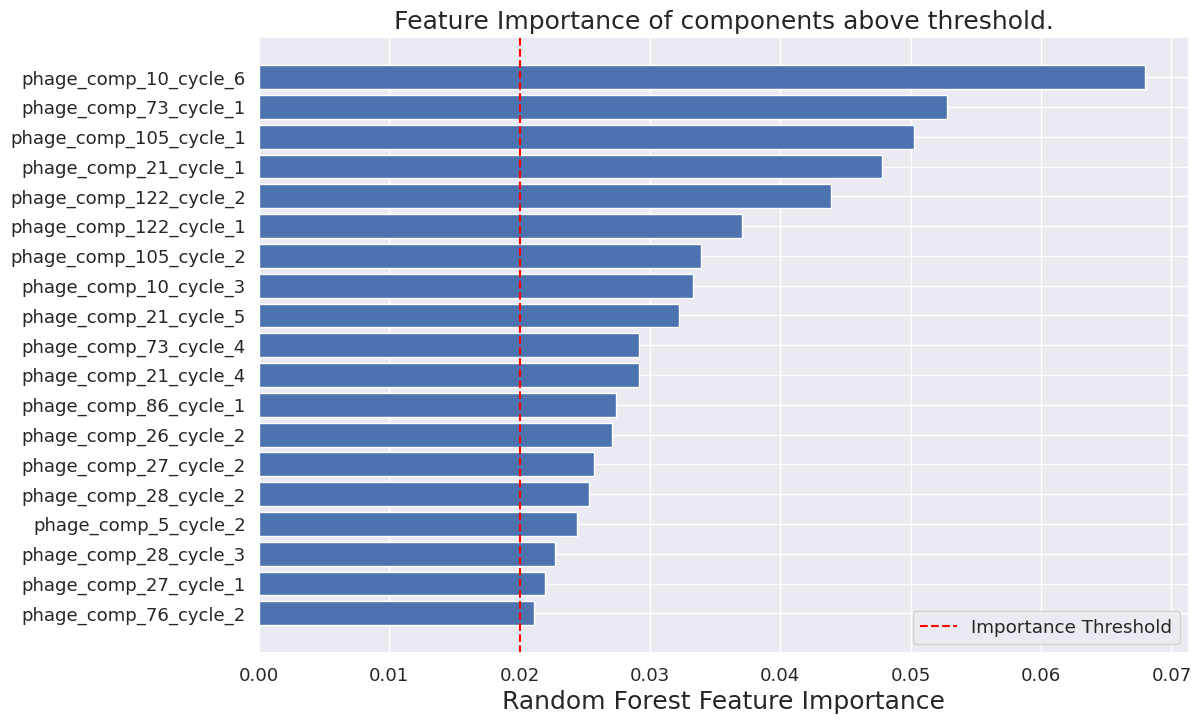

In [342]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('Data3.tsv', delimiter='\t')
# Define columns to exclude from features
patient_information = ["patient_ID","seqID_virome", "diagnosis"]
                       # "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare",
                       # "type_flare", "disease_status", "current_medications"]

# Create your feature matrix (X) and target vector (y)
data_for_x = data.drop(patient_information, axis=1)
feature_names = data_for_x.columns.tolist()
# print(feature_names)
X = pd.DataFrame(data_for_x, columns=feature_names)
y = data['diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

# Define the model and fit it
rf = RandomForestClassifier(n_estimators=100, random_state=12)
rf.fit(X_train, y_train)

# Set a threshold for feature importance
threshold = 0.02  # You can adjust this threshold as needed

# Filter features based on importance threshold
important_features = [feature_names[i] for i, importance in enumerate(rf.feature_importances_) if importance >= threshold]

# Sort the important features by importance (highest to lowest)
sorted_important_features = sorted(
    [(feature, importance) for feature, importance in zip(feature_names, rf.feature_importances_) if importance >= threshold],
    key=lambda x: x[1], reverse=False
)

# Print the sorted important features
for feature, importance in sorted_important_features:
    print(f"{feature}")


# Create a horizontal bar chart for sorted feature importances
plt.figure(figsize=(12, 8))  # Adjust the figure size

# Sort the features by importance (lowest to highest)
sorted_idx = [feature_names.index(feature) for feature, _ in sorted_important_features]
sorted_importance = [importance for _, importance in sorted_important_features]

plt.barh(range(len(sorted_idx)), sorted_importance)
plt.yticks(range(len(sorted_idx)), [feature for feature, _ in sorted_important_features])
plt.axvline(x=threshold, color='red', linestyle='--', label='Importance Threshold')  # Add the threshold line
plt.xlabel("Random Forest Feature Importance")
plt.title('Feature Importance of components above threshold.')
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
# Save the figure
plt.savefig('Feature_importance_above_threshold_sorted.png', dpi=300, bbox_inches='tight', format="png")

# Show the plot
plt.legend()
plt.show()

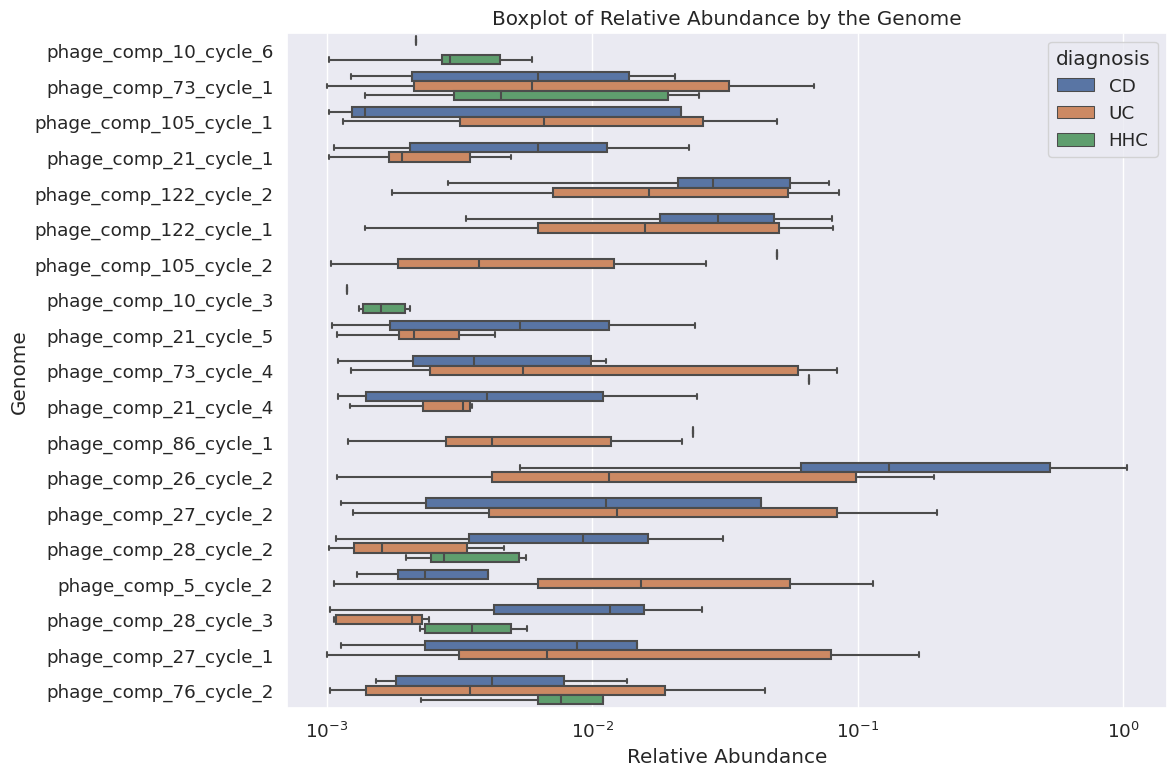

In [334]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

data_new = pd.read_csv('Data3.tsv', delimiter='\t')
# print(data_new)
melted_df = pd.melt(data_new, id_vars=['seqID_virome', 'patient_ID', 'diagnosis'], var_name='Genome', value_name='Relative_Abundance')
melted_df = melted_df[['seqID_virome', 'patient_ID', 'Genome', 'Relative_Abundance', 'diagnosis']]
melted_df = melted_df[melted_df['Relative_Abundance'] != 0]
melted_df = melted_df[melted_df['diagnosis'] != 'Campylobacter']

High_importance_genomes_001 = ['phage_comp_10_cycle_6', 'phage_comp_73_cycle_1', 'phage_comp_105_cycle_1','phage_comp_21_cycle_1', 'phage_comp_122_cycle_2',
                          'phage_comp_122_cycle_1', 'phage_comp_105_cycle_2', 'phage_comp_10_cycle_3', 'phage_comp_21_cycle_5', 'phage_comp_73_cycle_4',
                          'phage_comp_21_cycle_4', 'phage_comp_86_cycle_1', 'phage_comp_26_cycle_2', 'phage_comp_27_cycle_2', 'phage_comp_28_cycle_2',
                          'phage_comp_5_cycle_2', 'phage_comp_28_cycle_3', 'phage_comp_27_cycle_1', 'phage_comp_76_cycle_2']
melted_df = melted_df[melted_df['Genome'].isin(High_importance_genomes_001)]

# print(melted_df)
# High_importance_genomes_03 = ['phage_comp_73_cycle_1' ,'phage_comp_26_cycle_2', 'phage_comp_122_cycle_2', 'phage_comp_122_cycle_1', 'phage_comp_26_cycle_1', 
#                            'phage_comp_27_cycle_2', 'phage_comp_27_cycle_1', 'phage_comp_73_cycle_4', 'phage_comp_87_cycle_2', 'phage_comp_5_cycle_3', 
#                            'phage_comp_31_cycle_4', 'phage_comp_5_cycle_2', 'phage_comp_31_cycle_3', 'phage_comp_5_cycle_1', 'phage_comp_31_cycle_2']

# Create a boxplot using Seaborn
plt.figure(figsize=(12,8))  # Set the figure size
# Set the X-axis to logarithmic scale
plt.xscale('log')
sns.boxplot(x='Relative_Abundance', y='Genome', hue='diagnosis', data=melted_df, order=High_importance_genomes_001, showfliers=False)

# Add labels and a title
plt.xlabel('Relative Abundance')
plt.ylabel('Genome')
plt.title('Boxplot of Relative Abundance by the Genome')
plt.savefig('Boxplot of Relative Abundance by the Genome.png', dpi=300, bbox_inches='tight', format="png")
# Show the plot
plt.legend(title='diagnosis', loc='upper right')  # Add a legend
plt.tight_layout()
plt.show()

In [320]:
import csv

# Generating the dataframe
data_new = pd.read_csv('Data3.tsv', delimiter='\t')
# print(data_new)
melted_df = pd.melt(data_new, id_vars=['seqID_virome', 'patient_ID', 'diagnosis'], var_name='Genome', value_name='Relative_Abundance')
melted_df = melted_df[['seqID_virome', 'patient_ID', 'Genome', 'Relative_Abundance', 'diagnosis']]
# melted_df = melted_df[melted_df['Relative_Abundance'] != 0]
melted_df = melted_df[melted_df['diagnosis'] != 'Campylobacter']

# T-testing pairwise between the diagnosis: 
diagnosis = melted_df['diagnosis'].unique()
combination  = list(combinations(diagnosis, 2))
# print(combination)
alpha = 0.05
T_test_dict_genomes = {}
for comp in High_importance_genomes_001:
    # print(comp)
    filtered_df = melted_df[melted_df['Genome'] == comp]
    T_test_dict_genomes[comp] = {}
    for m1, m2 in combination: 
        group_1_data = filtered_df[filtered_df['diagnosis'] == m1]['Relative_Abundance']
        # print(group_1_data)
        group_2_data = filtered_df[filtered_df['diagnosis'] == m2]['Relative_Abundance']
        t_statistic, p_value = stats.ttest_ind(group_1_data, group_2_data)
        # print(f"T-test between {m1} and {m2}:")
        # print(f"T-statistic: {t_statistic}")
        # print(f"P-value: {p_value}")
        T_test_dict_genomes[comp][f'{m1} vs {m2}'] = {'T-statistic' : t_statistic, 'P-value' : p_value}
print(T_test_dict_genomes)



{'phage_comp_10_cycle_6': {'UC vs CD': {'T-statistic': -1.1369365259674042, 'P-value': 0.2569600001516738}, 'UC vs HHC': {'T-statistic': -15.098478432827845, 'P-value': 1.9986038849149844e-29}, 'CD vs HHC': {'T-statistic': -12.620204685365106, 'P-value': 6.038415087675911e-22}}, 'phage_comp_73_cycle_1': {'UC vs CD': {'T-statistic': 1.7741302290965053, 'P-value': 0.0776020829965364}, 'UC vs HHC': {'T-statistic': 0.513708891519039, 'P-value': 0.6084080705831166}, 'CD vs HHC': {'T-statistic': -2.534013165598829, 'P-value': 0.012930187393774328}}, 'phage_comp_105_cycle_1': {'UC vs CD': {'T-statistic': 1.5247690712834427, 'P-value': 0.12893689756284368}, 'UC vs HHC': {'T-statistic': 1.0773434978875, 'P-value': 0.28350597257642735}, 'CD vs HHC': {'T-statistic': 0.3552604460081103, 'P-value': 0.7231903988645839}}, 'phage_comp_21_cycle_1': {'UC vs CD': {'T-statistic': -1.5594537245973579, 'P-value': 0.12051049138393186}, 'UC vs HHC': {'T-statistic': 0.7788653043222079, 'P-value': 0.43760513238

In [323]:
import pandas as pd
import matplotlib.pyplot as plt

def Metadata_analysis(patient_ID):
    patient_information = ["patient_ID","IBD","day","month","year", "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare", 
                           "type_flare", "disease_status", "current_medications", "seqID_virome"] 
    data_frame = pd.read_csv("PHAGE_BUBBLE/Freeze3_metadata.csv", header=0,
                             dtype=str, na_values=['NA'],
                             skip_blank_lines=True,
                             true_values=['true'], false_values=['false'],
                             nrows=None)

    patient_ID_whole_metadata = data_frame[data_frame["patient_ID"] == patient_ID]
    selected_data = patient_ID_whole_metadata[patient_information]
    selected_data = selected_data.dropna(subset=["seqID_virome"])

    
    selected_data['FC_categories'].replace(['highly_elevated','elevated','above_normal','normal','below_LOD'],[4,3,2,1,0],inplace=True)
    selected_data['FC_categories_4'].replace(['highly_elevated','elevated','above_normal','normal'],[4,3,2,1],inplace=True)
    selected_data['inflammation'].replace(['inactive','active'],[0,1],inplace=True)
    selected_data['flare'].replace(['no','yes'],[0,1],inplace=True)
    print(selected_data)
    
    
    Dict_1 = { 'Time' : [f"{day}-{month}-{year}" for day, month, year in zip(selected_data['day'], selected_data['month'], selected_data['year'])]}
    # Dict_1['diagnosis'] = [diagnosis for diagnosis in selected_data['diagnosis']]
    Dict_1['FC_categories'] = [FC_categories for FC_categories in selected_data['FC_categories']]
    Dict_1['FC_categories_4'] = [FC_categories_4 for FC_categories_4 in selected_data['FC_categories_4']]
    Dict_1['inflammation'] = [inflammation for inflammation in selected_data['inflammation']]
    Dict_1['flare'] = [flare for flare in selected_data['flare']]
    
    from datetime import datetime
    Dict_1['Time'] = [datetime.strptime(date, '%d-%m-%Y') for date in Dict_1['Time']]

    sorted_data_tuples = sorted(zip(*Dict_1.values()), key=lambda x: x[0])
    
    Dict_1 = {'Time': [item[0] for item in sorted_data_tuples], 'FC_categories': [item[1] for item in sorted_data_tuples], 
              'FC_categories_4': [item[2] for item in sorted_data_tuples], 'inflammation': [item[3] for item in sorted_data_tuples], 
              'flare': [item[4] for item in sorted_data_tuples]}
    
    return Dict_1

def column_graph(patient):
    data = Metadata_analysis(patient)
    data['Time'] = pd.to_datetime(data['Time'], format='%d-%m-%Y')
    print(data)
    df = pd.DataFrame(data)
    # df = df.sort_values(by = 'Time')
    df.set_index('Time', inplace=True)
    
    df.plot(kind='bar', figsize=(30, 6), grid=True)
    plt.xlabel('Time Points')
    plt.ylabel('Values')
    plt.title(f'Time Series Bar Graph for Different Categories of {patient}')
    plt.legend(title='Categories')
    # plt.savefig(f"{patient}_Col_Graph.png", dpi=300, bbox_inches='tight', format="png")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)

    # Show the graph
    plt.show()
    
Metadata_analysis('282')
# column_graph('282')

    patient_ID  IBD day month  year diagnosis  FC_categories  FC_categories_4  \
335        282  yes  11     5  2016        CD            2.0              2.0   
358        282  yes  14     6  2016        CD            3.0              3.0   
380        282  yes  11     7  2016        CD            4.0              4.0   
405        282  yes  30     8  2016        CD            2.0              2.0   
422        282  yes  27     6  2016        CD            2.0              2.0   
459        282  yes  12     4  2016        CD            NaN              NaN   
467        282  yes  26     1  2017        CD            2.0              2.0   
468        282  yes  14     3  2017        CD            0.0              1.0   
485        282  yes  10    10  2016        CD            1.0              1.0   
488        282  yes  31     1  2017        CD            1.0              1.0   
491        282  yes  23     4  2017        CD            0.0              1.0   
498        282  yes   8    1

{'Time': [datetime.datetime(2016, 4, 12, 0, 0),
  datetime.datetime(2016, 5, 11, 0, 0),
  datetime.datetime(2016, 6, 14, 0, 0),
  datetime.datetime(2016, 6, 27, 0, 0),
  datetime.datetime(2016, 7, 11, 0, 0),
  datetime.datetime(2016, 8, 30, 0, 0),
  datetime.datetime(2016, 10, 10, 0, 0),
  datetime.datetime(2016, 11, 24, 0, 0),
  datetime.datetime(2016, 12, 2, 0, 0),
  datetime.datetime(2016, 12, 8, 0, 0),
  datetime.datetime(2017, 1, 26, 0, 0),
  datetime.datetime(2017, 1, 31, 0, 0),
  datetime.datetime(2017, 3, 14, 0, 0),
  datetime.datetime(2017, 4, 23, 0, 0)],
 'FC_categories': [nan,
  2.0,
  3.0,
  2.0,
  4.0,
  2.0,
  1.0,
  nan,
  1.0,
  2.0,
  2.0,
  1.0,
  0.0,
  0.0],
 'FC_categories_4': [nan,
  2.0,
  3.0,
  2.0,
  4.0,
  2.0,
  1.0,
  nan,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0],
 'inflammation': [nan,
  0.0,
  1.0,
  0.0,
  1.0,
  0.0,
  0.0,
  nan,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'flare': [0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]}

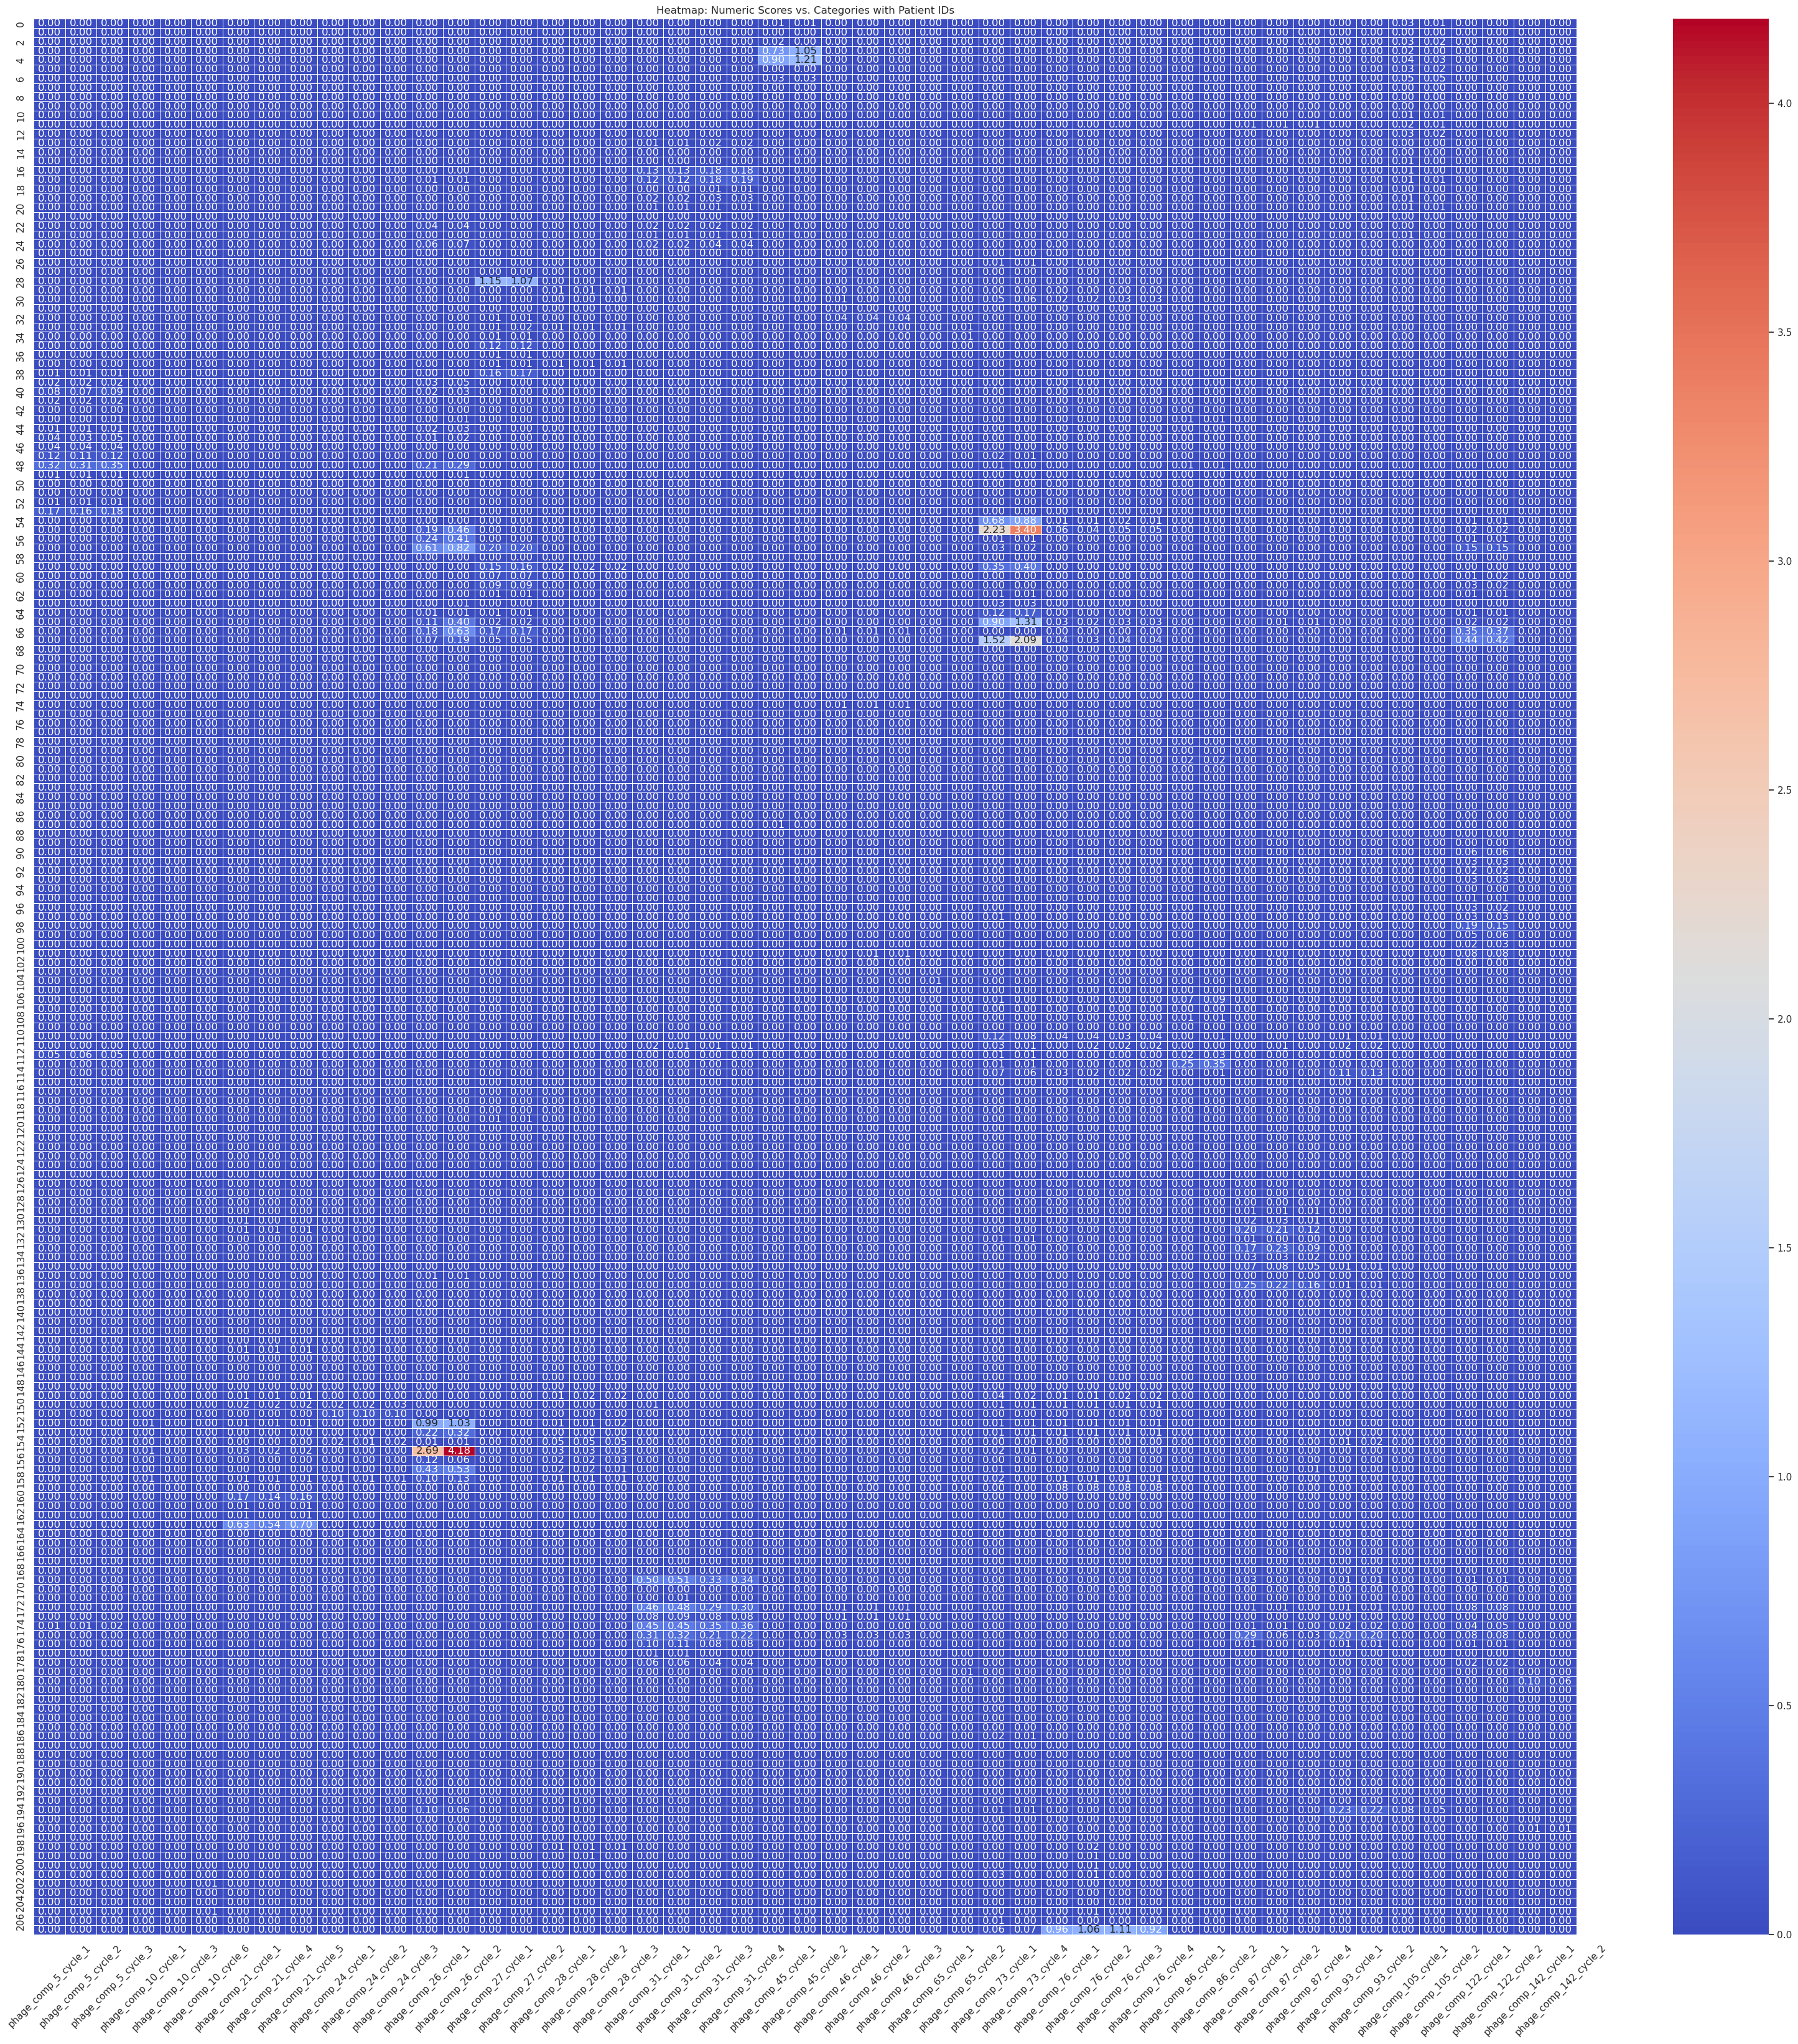

In [408]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame with numeric scores for categories
df = pd.read_csv('Data_for_heat_map.tsv', delimiter='\t')
patient_information_heatmap = ['seqID_virome', 'patient_ID','diagnosis']

# Select the numeric score columns
numeric_columns = ['seqID_virome', 'patient_ID', "diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare"]

data = df.drop(numeric_columns, axis=1)
# melted_df = pd.melt(df, id_vars=['seqID_virome', 'patient_ID', 'diagnosis'], var_name='Genome', value_name='Relative_Abundance')
# melted_df = melted_df[['seqID_virome', 'patient_ID', 'Genome', 'Relative_Abundance', 'diagnosis']]
# corr_data = melted_df.pivot("patient_ID","Genome","Relative_Abundance")
High_importance_genomes_001 = ['phage_comp_10_cycle_6', 'phage_comp_73_cycle_1', 'phage_comp_105_cycle_1','phage_comp_21_cycle_1', 'phage_comp_122_cycle_2',
                          'phage_comp_122_cycle_1', 'phage_comp_105_cycle_2', 'phage_comp_10_cycle_3', 'phage_comp_21_cycle_5', 'phage_comp_73_cycle_4',
                          'phage_comp_21_cycle_4', 'phage_comp_86_cycle_1', 'phage_comp_26_cycle_2', 'phage_comp_27_cycle_2', 'phage_comp_28_cycle_2',
                          'phage_comp_5_cycle_2', 'phage_comp_28_cycle_3', 'phage_comp_27_cycle_1', 'phage_comp_76_cycle_2']

# df = df[High_importance_genomes_001]
correlation_matrix = data.corr()
y = df['patient_ID']
sns.set(style='whitegrid')
plt.figure(figsize=(40, 40))
# # heatmap_data = df.pivot(index='Patient ID', columns='Variant', values=columns_to_include)
sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
# sns.clustermap(correlation_matrix, cmap="coolwarm", linewidths=0.5)

# Customize labels and title
plt.title('Heatmap: Numeric Scores vs. Categories with Patient IDs')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.savefig('Heatmap: Numeric Scores vs. Categories with Patient IDs.png')
# Show the plot
plt.show()


     year month  passengers
0    1949   Jan         112
1    1949   Feb         118
2    1949   Mar         132
3    1949   Apr         129
4    1949   May         121
..    ...   ...         ...
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432

[144 rows x 3 columns]
year   1949  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  1960
month                                                                        
Jan     112   115   145   171   196   204   242   284   315   340   360   417
Feb     118   126   150   180   196   188   233   277   301   318   342   391
Mar     132   141   178   193   236   235   267   317   356   362   406   419
Apr     129   135   163   181   235   227   269   313   348   348   396   461
May     121   125   172   183   229   234   270   318   355   363   420   472
Jun     135   149   178   218   243   264   315   374   422   435   472   535
Jul     148   17

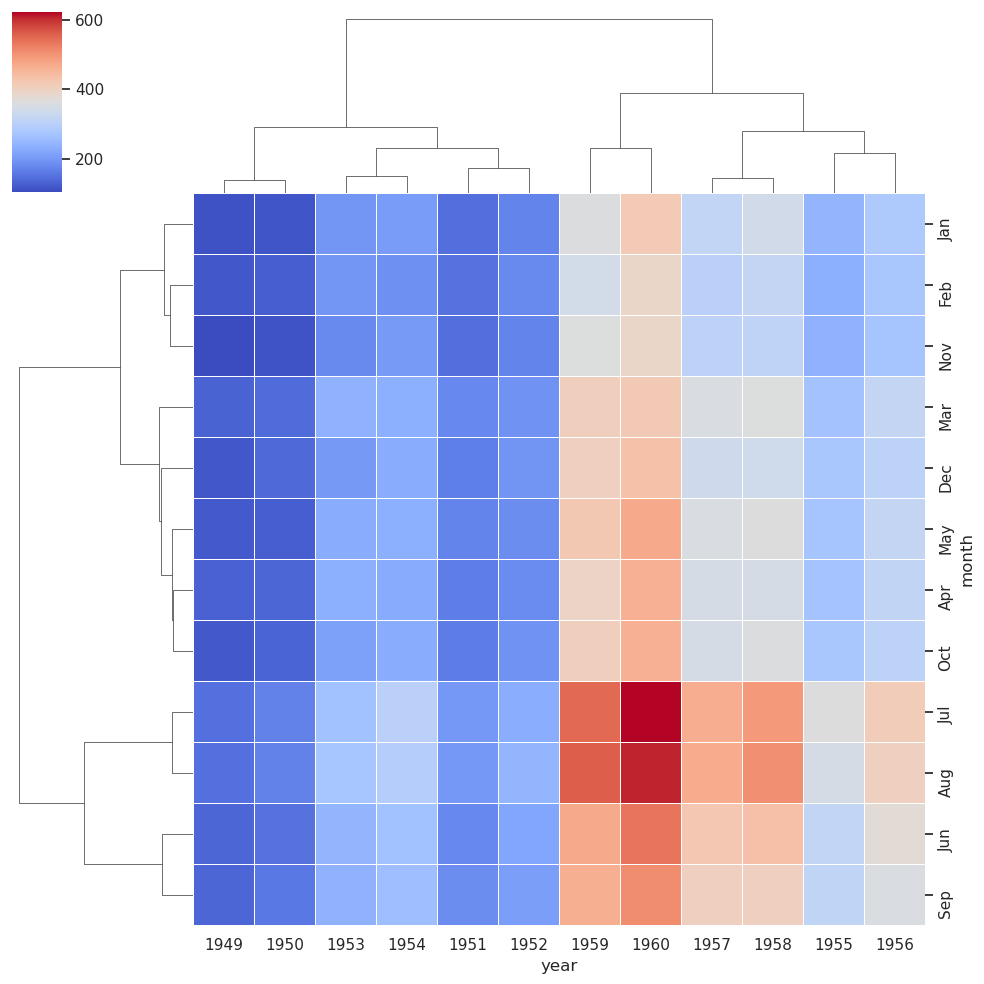

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the 'flights' dataset
data = sns.load_dataset("flights")

# Pivot the data to create a correlation matrix
corr_data = data.pivot("month", "year", "passengers")
print(data)
print(corr_data)
# Create a clustered heatmap
sns.clustermap(corr_data, cmap="coolwarm", linewidths=0.5)

# Show the plot
plt.show()


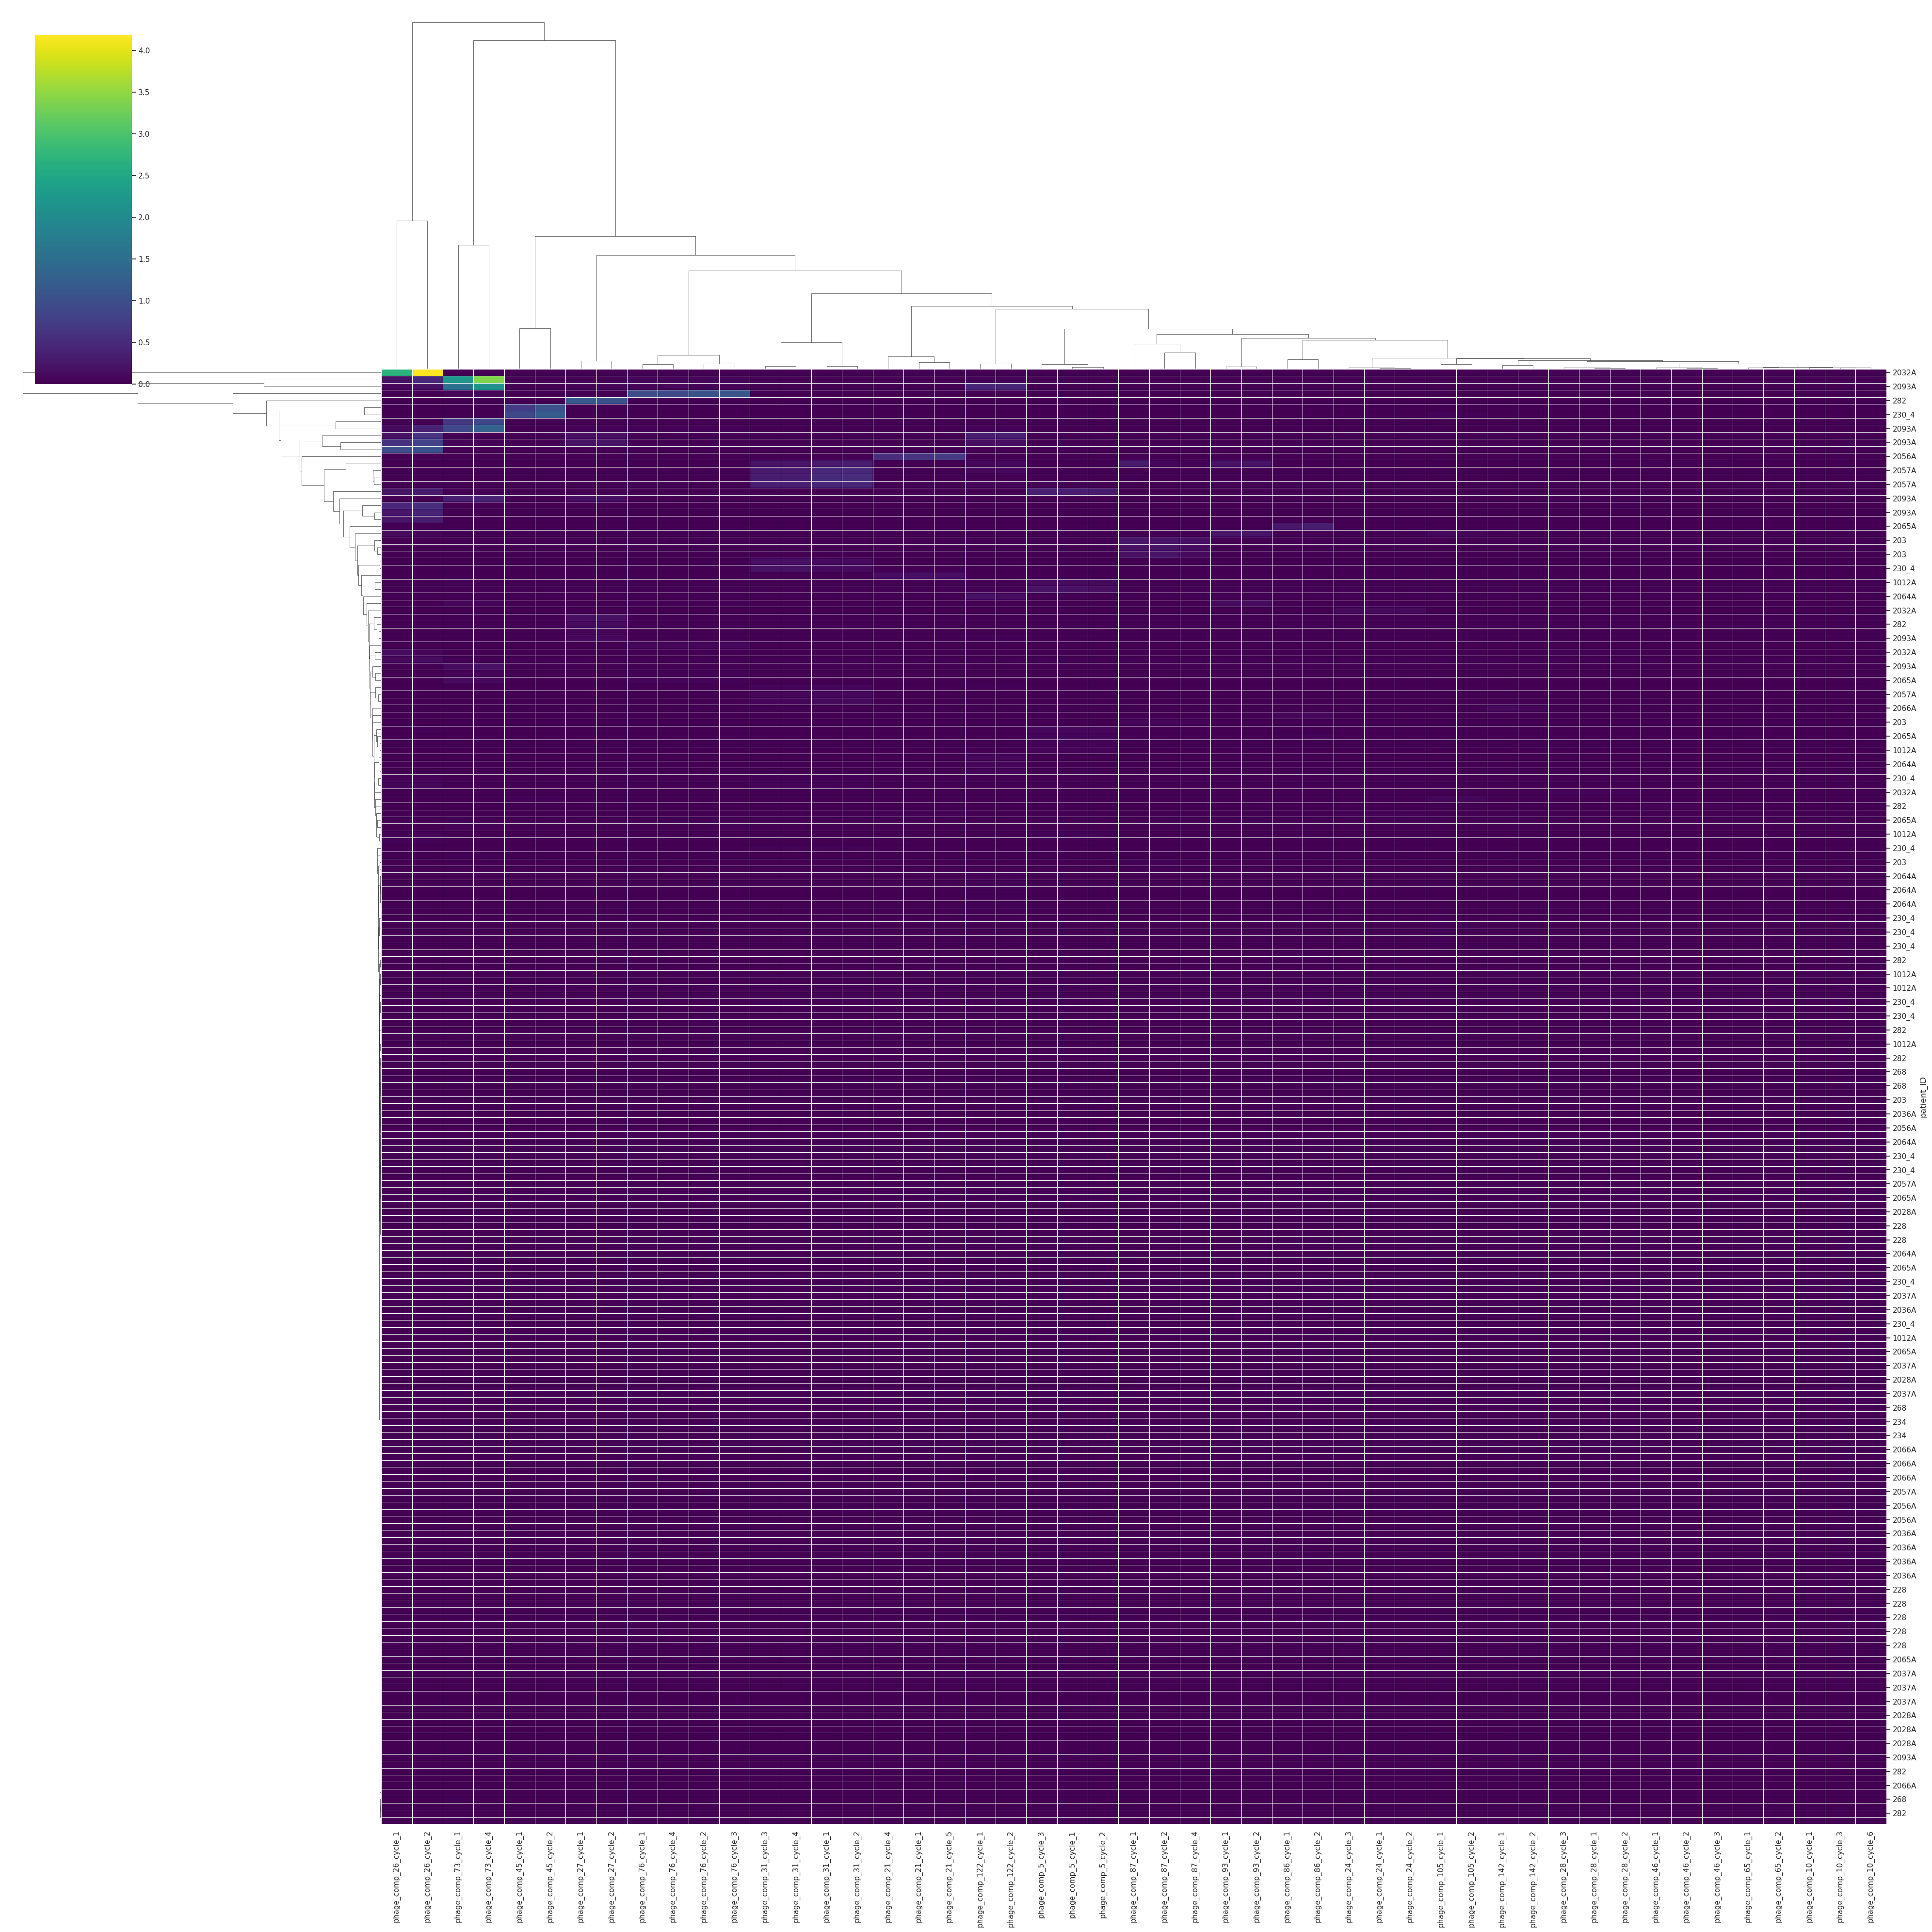

In [440]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Data_for_heat_map.tsv', delimiter='\t')
numeric_columns = ['seqID_virome',"diagnosis", "FC_categories", "FC_categories_4", "inflammation", "flare"]

df = df.drop(numeric_columns, axis=1)
df.set_index(['patient_ID'], inplace=True)

# plt.xscale('log')
# df = df.T
# correlation_matrix = df.corr()
sns.clustermap(df, cmap='coolwarm', figsize=(40, 40), annot=False, linewidths=0.5)
plt.savefig('Heatmap: Numeric Scores vs. Categories with Patient IDs.png')
plt.show()
# correlation_matrix = df.corr()
# sns.heatmap(df, cmap='coolwarm', annot=False, linewidths=0.5)
# plt.show()

ValueError: Could not interpret input 'Classification'

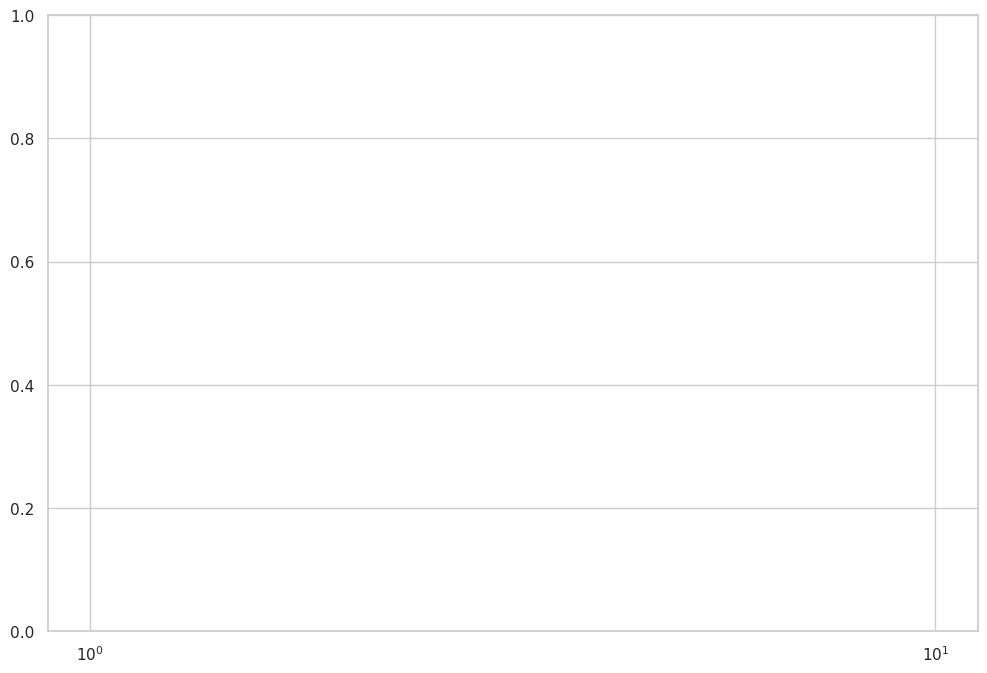

In [364]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

data_new = pd.read_csv('BIGTABLE_DOMINANCE_DETERMINATION_filtered_with_mean.tsv', delimiter='\t')
# print(data_new)
# melted_df = pd.melt(data_new, id_vars=['seqID_virome', 'patient_ID', 'diagnosis'], var_name='Genome', value_name='Relative_Abundance')
# melted_df = melted_df[['seqID_virome', 'patient_ID', 'Genome', 'Relative_Abundance', 'diagnosis']]
# melted_df = melted_df[melted_df['Relative_Abundance'] != 0]
# melted_df = melted_df[melted_df['diagnosis'] != 'Campylobacter']

# High_importance_genomes_001 = ['phage_comp_10_cycle_6', 'phage_comp_73_cycle_1', 'phage_comp_105_cycle_1','phage_comp_21_cycle_1', 'phage_comp_122_cycle_2',
#                           'phage_comp_122_cycle_1', 'phage_comp_105_cycle_2', 'phage_comp_10_cycle_3', 'phage_comp_21_cycle_5', 'phage_comp_73_cycle_4',
#                           'phage_comp_21_cycle_4', 'phage_comp_86_cycle_1', 'phage_comp_26_cycle_2', 'phage_comp_27_cycle_2', 'phage_comp_28_cycle_2',
#                           'phage_comp_5_cycle_2', 'phage_comp_28_cycle_3', 'phage_comp_27_cycle_1', 'phage_comp_76_cycle_2']
# melted_df = melted_df[melted_df['Genome'].isin(High_importance_genomes_001)]

# print(melted_df)
# High_importance_genomes_03 = ['phage_comp_73_cycle_1' ,'phage_comp_26_cycle_2', 'phage_comp_122_cycle_2', 'phage_comp_122_cycle_1', 'phage_comp_26_cycle_1', 
#                            'phage_comp_27_cycle_2', 'phage_comp_27_cycle_1', 'phage_comp_73_cycle_4', 'phage_comp_87_cycle_2', 'phage_comp_5_cycle_3', 
#                            'phage_comp_31_cycle_4', 'phage_comp_5_cycle_2', 'phage_comp_31_cycle_3', 'phage_comp_5_cycle_1', 'phage_comp_31_cycle_2']

# Create a boxplot using Seaborn
plt.figure(figsize=(12,8))  # Set the figure size
# Set the X-axis to logarithmic scale
# plt.xscale('log')
sns.boxplot(x='Mean', y='Classification', hue='categories_dominance', data=data_new, showfliers=False)

# Add labels and a title
plt.xlabel('Mean of Relative Abundance')
plt.ylabel('Classification')
plt.title('Boxplot of Means of relative abundance comparing the classification with dominance categories')
plt.savefig('Boxplot of Means of relative abundance comparing the classification with dominance categories.png', dpi=300, bbox_inches='tight', format="png")
# Show the plot
plt.legend(title='diagnosis', loc='upper right')  # Add a legend
plt.tight_layout()
plt.show()

In [437]:
Component = ['phage_comp_5', 'phage_comp_10', 'phage_comp_21', 'phage_comp_24', 'phage_comp_26', 'phage_comp_27', 'phage_comp_28',
 'phage_comp_31', 'phage_comp_45', 'phage_comp_46', 'phage_comp_65', 'phage_comp_73', 'phage_comp_76', 'phage_comp_86',
 'phage_comp_87', 'phage_comp_93', 'phage_comp_105', 'phage_comp_122', 'phage_comp_142']

prophage = "prophage"
temperate_phage = 'temperate'
lytic_phage = 'lytic'
unknown = 'unknown'


Annotation_dict = {'phage_comp_5' : unknown, 'phage_comp_10' : lytic_phage, 'phage_comp_21' : temperate_phage, 'phage_comp_24': temperate_phage, 
                   'phage_comp_26' : lytic_phage, 'phage_comp_27' : temperate_phage, 'phage_comp_28': lytic_phage, 'phage_comp_31' : temperate_phage,
                   'phage_comp_45' : lytic_phage, 'phage_comp_46' : temperate_phage, 'phage_comp_65' : unknown, 'phage_comp_73': lytic_phage, 
                   'phage_comp_76' : unknown, 'phage_comp_86' : lytic_phage,  'phage_comp_87' : temperate_phage, 'phage_comp_93' : temperate_phage, 
                   'phage_comp_105' : unknown, 'phage_comp_122' : temperate_phage, 'phage_comp_142' : lytic_phage}


In [438]:
from collections import defaultdict

count_dict = defaultdict(int)

# Define the categories
categories = [unknown, lytic_phage, temperate_phage, prophage]

# Count the occurrences
for key, value in Annotation_dict.items():
    if value in categories:
        count_dict[value] += 1
    else:
        count_dict['prophage'] += 1

# Print the counts
for category, count in count_dict.items():
    print(f'{category}: {count}')


unknown: 4
lytic: 7
temperate: 8
